# Emitting Spot Size measurement on 2020-01-31

## Load all the data

In [1]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
sns.set()
import getopt
import sys
import datetime
from scipy.interpolate import interp1d
from NGDataObject import NGDataObject
from scipy.optimize import curve_fit
from scipy import optimize

#*******************************
# CONSTANTS
#*******************************
# connection to database
CREDENTIALS_FILE = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
DB = "NG_twofast_DB" # name of the database
HOST = "twofast-RPi3-0"  # database host

# LOOKUP TABLES
LUT_PRESSURE_ION_SOURCE = "/Users/hkromer/02_PhD/01.github/phd/01_neutron_generator_contol/LUT_pressure_ion_source.txt"

### Load from database

In [ ]:
# reference detectors
# dose
# HV
DAY = "2020-01-31"
# read password and user to connect to database
credentials = pd.read_csv(CREDENTIALS_FILE, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]


#*******************************
# GET DATA
#*******************************

# connect to DB
con = NGDataObject(host = HOST, database=DB, user=user, password=pw)

# get dose
query = "SELECT * FROM data_dose WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_dose = con.get_from_database(query=query)

# get HV
query = "SELECT * FROM data_HV WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_hv = con.get_from_database(query=query)
data_hv['HV_current_x100'] = data_hv['HV_current']*100.0

# get pressure
query = "SELECT * FROM data_pressure WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_pressure = con.get_from_database(query=query)

# get reference detectors
query = "SELECT * FROM data_referenceDetectors WHERE DATE(time) > '2020-01-30 20:00:00'" 
data_reference_full = con.get_from_database(query=query)

# get microwave power
query = "SELECT * FROM microwave_generator_power WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_microwave_power_full = con.get_from_database(query=query)

# get microwave frequency
query = "SELECT * FROM microwave_generator_frequency WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_microwave_frequency_full = con.get_from_database(query=query)

# save to file
data_reference_full['sum_counts'] = data_reference_full['counts_D1'] + data_reference_full['counts_D2'] + data_reference_full['counts_D3'] + data_reference_full['counts_D4'] 

path = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/DATA/emitting_spot_size_2020-01-31/'
data_dose.to_csv(f'{path}/2020-02-07_dose.csv')
data_hv.to_csv(f'{path}/2020-02-07_hv.csv')
data_pressure.to_csv(f'{path}/2020-02-07_pressure.csv')
data_reference_full.to_csv(f'{path}/2020-02-07_reference_detectors.csv')
data_microwave_power_full.to_csv(f'{path}/2020-02-07_microwave_power.csv')
data_microwave_frequency_full.to_csv(f'{path}/2020-02-07_microwave_frequency.csv')

### Load from stored csv files

In [2]:
path = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/DATA/emitting_spot_size_2020-01-31/'
DAY = "2020-01-31"

data_dose = pd.read_csv(f'{path}/2020-02-07_dose.csv', index_col=0)
data_dose.index = pd.to_datetime(data_dose.index)

data_hv = pd.read_csv(f'{path}/2020-02-07_hv.csv', index_col=0)
data_hv.index = pd.to_datetime(data_hv.index)

data_pressure = pd.read_csv(f'{path}/2020-02-07_pressure.csv', index_col=0)
data_pressure.index = pd.to_datetime(data_pressure.index)

data_reference_full = pd.read_csv(f'{path}/2020-02-07_reference_detectors.csv', index_col=0)
data_reference_full.index = pd.to_datetime(data_reference_full.index)

data_microwave_power_full = pd.read_csv(f'{path}/2020-02-07_microwave_power.csv', index_col=0)
data_microwave_power_full.index = pd.to_datetime(data_microwave_power_full.index)

data_microwave_frequency_full = pd.read_csv(f'{path}/2020-02-07_microwave_frequency.csv', index_col=0)
data_microwave_frequency_full.index = pd.to_datetime(data_microwave_frequency_full.index)


#### Select only relevant time

In [3]:
start = "2020-01-31 07:55:00"
end = "2020-01-31 14:45:00"

data_dose_s = data_dose.loc[start:end, ]
data_hv_s = data_hv.loc[start:end, ]
data_reference_s = data_reference_full.loc[start:end, ]


### Counts in emitting spot size detector

In [4]:
# tungsten counts
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-31.EmittingSpot/2020-01-31_readout.csv'
data_ess = pd.read_csv(fname, index_col='time')
data_ess = data_ess[['readtime', 'value']]
data_ess.index = pd.to_datetime(data_ess.index)
# background measurement 
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-30.EmittingSpot.Leadshield/2020-01-31_readout.csv'
data_ess_BG = pd.read_csv(fname, index_col='time')
data_ess_BG = data_ess_BG[['readtime', 'value']]
data_ess_BG.index = pd.to_datetime(data_ess_BG.index)
data_ess_BG.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1507 entries, 2020-01-30 18:47:39.153445 to 2020-01-31 07:40:25.190357
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   readtime  1507 non-null   float64
 1   value     1507 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 35.3 KB


#### Background correction of emitting spot size detector and reference detector

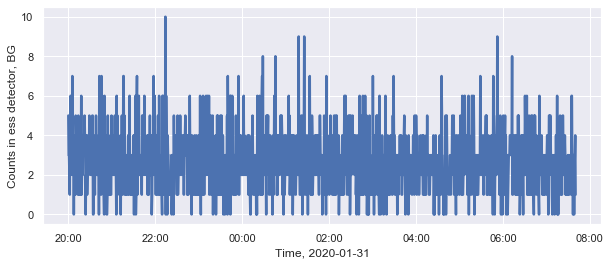

Mean background counts per 30 s interval: 2.688644688644689 1/(30s)
Mean background counts per second: 0.08905155963979494 1/s
Total counts: 3670
Total time duration: 0 days 11:40:22.783910
Total time duration: 42022 s
Total meas positions expected in that time: 1391.8256491785903 
Total measurement points: (1365, 2)
Total counts per time duration: 0.08733520536861644 1/s


In [5]:
start_BG = "2020-01-30 20:00:00"
end_BG = "2020-01-31 08:00:00"

data_ess_BG = data_ess_BG.loc[start_BG:end_BG, ]
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ess_BG.index, y='value', data=data_ess_BG, ax=ax)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in ess detector, BG')
ax.set_xlabel(f'Time, {DAY}')
plt.show()
print(f"Mean background counts per 30 s interval: {data_ess_BG.value.mean()} 1/(30s)")
counting_time = data_ess_BG['readtime'].value_counts().index[0]/1000
counts_per_s_BG = data_ess_BG.value.mean()/counting_time
print(f"Mean background counts per second: {counts_per_s_BG} 1/s")
print(f"Total counts: {data_ess_BG.value.sum()}")
timedelta = data_ess_BG.index[-1]-data_ess_BG.index[0] 
print(f"Total time duration: {timedelta}")
print(f"Total time duration: {timedelta.seconds} s")
print(f"Total meas positions expected in that time: {timedelta.seconds/counting_time} ")
print(f"Total measurement points: {data_ess_BG.shape}")
counts_per_s_BG_agg = data_ess_BG.value.sum()/timedelta.seconds
print(f"Total counts per time duration: {counts_per_s_BG_agg} 1/s")

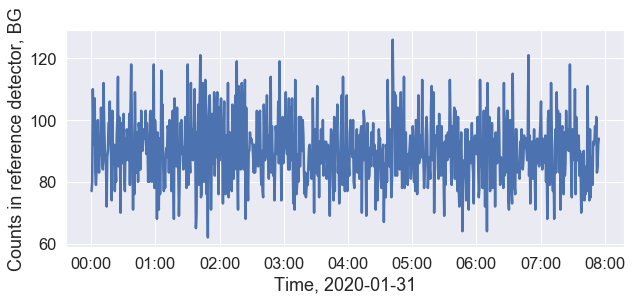

Mean background counts per 30 s interval: 90.21960297766749 1/(30s)
Mean background counts per second: 2.988195647114053 1/s
Total counts: 72717.0
Total time duration: 0 days 07:54:07.383517
Total time duration: 28447 s
Total meas positions expected in that time: 942.2032326444091 
Total measurement points: (806, 7)
Total counts per time duration: 2.5562273701972087 1/s


In [6]:
start_BG = "2020-01-30 20:00:00"
end_BG = "2020-01-31 07:55:00"

data_ref_BG = data_reference_full.loc[start_BG:end_BG, ]
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ref_BG.index, y='sum_counts', data=data_ref_BG, ax=ax)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in reference detector, BG')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

print(f"Mean background counts per 30 s interval: {data_ref_BG.sum_counts.mean()} 1/(30s)")
ref_counting_time = data_ref_BG['ard_time'].value_counts().index[0]/1000
ref_counts_per_s_BG = data_ref_BG.sum_counts.mean()/counting_time
print(f"Mean background counts per second: {ref_counts_per_s_BG} 1/s")
print(f"Total counts: {data_ref_BG.sum_counts.sum()}")
timedelta = data_ref_BG.index[-1]-data_ref_BG.index[0] 
print(f"Total time duration: {timedelta}")
print(f"Total time duration: {timedelta.seconds} s")
print(f"Total meas positions expected in that time: {timedelta.seconds/counting_time} ")
print(f"Total measurement points: {data_ref_BG.shape}")
ref_counts_per_s_BG_agg = data_ref_BG.sum_counts.sum()/timedelta.seconds
print(f"Total counts per time duration: {ref_counts_per_s_BG_agg} 1/s")

### Tungsten edge position

In [7]:
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-31.EmittingSpotSize.xlsx' 
data_pos = pd.read_excel(fname, header=4)
data_pos = data_pos[['Time', 'edge_pos', 'Comment']]
data_pos = data_pos.iloc[2:,:] # clear rows at beginning and end
data_pos['edge_pos'] = data_pos['edge_pos'].astype(np.float64)
data_pos['Time'] = data_pos['Time'].apply(lambda x: f'2020-01-31 {x}')
data_pos['Time'] = pd.to_datetime(data_pos['Time'])
data_pos.set_index('Time', inplace=True, drop=True)

## Some plots - database

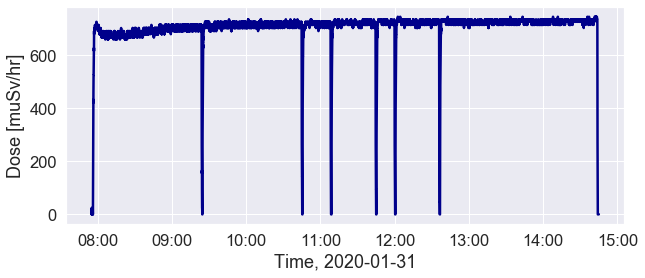

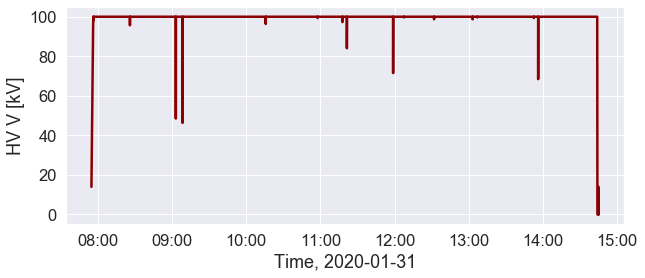

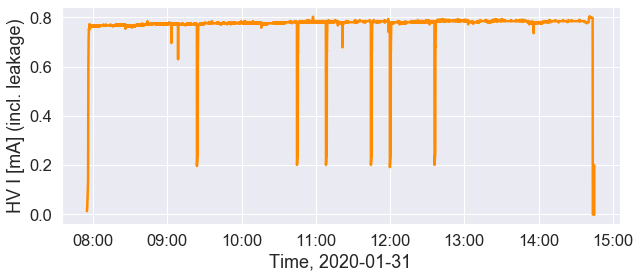

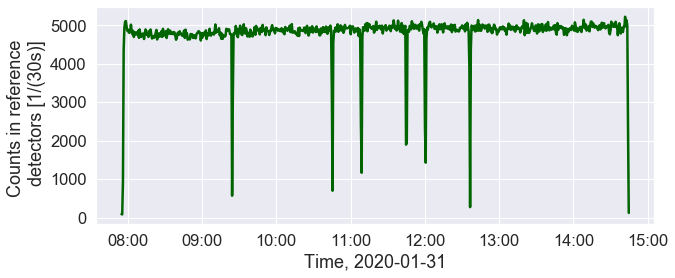

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose_s.index, y='dose_corrected', data=data_dose_s, ax=ax, color='darkblue')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Dose [muSv/hr]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv_s.index, y='HV_voltage', data=data_hv_s, ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV V [kV]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv_s.index, y='HV_current', data=data_hv_s, ax=ax, color='darkorange')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_reference_s.index, y='sum_counts', data=data_reference_s, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in reference \n detectors [1/(30s)]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

## ESS

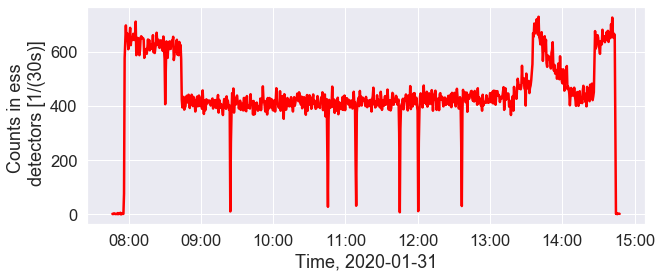

In [9]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ess.index, y='value', data=data_ess, ax=ax, color='red')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in ess \n detectors [1/(30s)]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

# Extract data for each tungsten position

### Tungsten edge position

In [10]:
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-31.EmittingSpotSize.xlsx' 
data_pos = pd.read_excel(fname, header=4)
data_pos = data_pos[['Time', 'edge_pos', 'Comment', 'analysis']]
data_pos = data_pos.iloc[2:,:] # clear rows at beginning and end
data_pos['edge_pos'] = data_pos['edge_pos'].astype(np.float64)
data_pos['Time'] = data_pos['Time'].apply(lambda x: f'2020-01-31 {x}')
data_pos['Time'] = pd.to_datetime(data_pos['Time'])
data_pos.set_index('Time', inplace=True, drop=True)
data_pos = data_pos[data_pos['analysis'] != 'remove']

## Adjust times using analysis column

In [11]:
# get the new time from the excel
data_pos_mod = data_pos[data_pos['analysis'].notnull()]
data_pos_mod.loc[:, 'analysis'] = data_pos_mod.loc[:, 'analysis'].apply(lambda x: f'2020-01-31 {x}')
data_pos_mod.loc[:, 'new_time'] = pd.to_datetime(data_pos_mod.loc[:,'analysis'])
# create dictionary for replacement
data_pos_mod = data_pos_mod[['new_time']]
dict_replace = data_pos_mod.to_dict()['new_time']

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.8/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/hkromer/anaconda3/envs/py3.7/lib/python3.8/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [12]:
# replace the column
data_pos['time'] = data_pos.index
data_pos['time'] = data_pos['time'].replace(dict_replace)
# make it new index
data_pos = data_pos.set_index('time', drop=True)
data_pos = data_pos[['edge_pos']]
data_pos['t0'] = data_pos.index
data_pos['t1'] = data_pos['t0'].shift(-1)

In [13]:
# replace in t0
dict_replace = {
    pd.Timestamp('2020-01-31 13:52:00'): pd.Timestamp('2020-01-31 13:52:30'),
    pd.Timestamp('2020-01-31 14:26:00'): pd.Timestamp('2020-01-31 14:28:00')
    
}
data_pos['t0'] = data_pos['t0'].replace(dict_replace)

# replace in t1
dict_replace = {
    pd.Timestamp('2020-01-31 08:45:00'): pd.Timestamp('2020-01-31 08:43:00'),
    pd.Timestamp('2020-01-31 13:36:00'): pd.Timestamp('2020-01-31 13:35:00')
}
data_pos['t1'] = data_pos['t1'].replace(dict_replace)

712.00, 588.00, 29.69


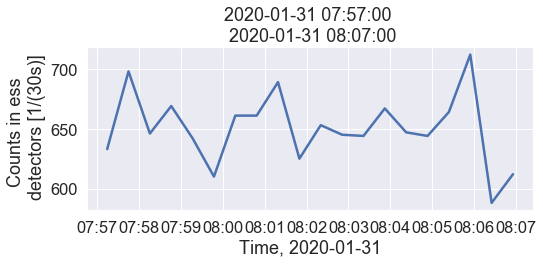

658.00, 578.00, 26.62


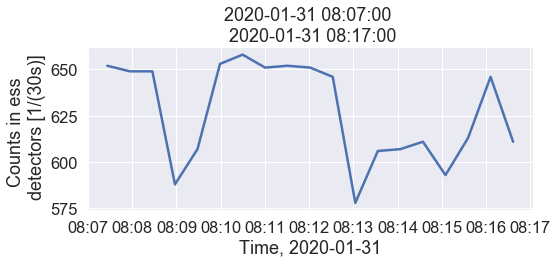

671.00, 596.00, 19.32


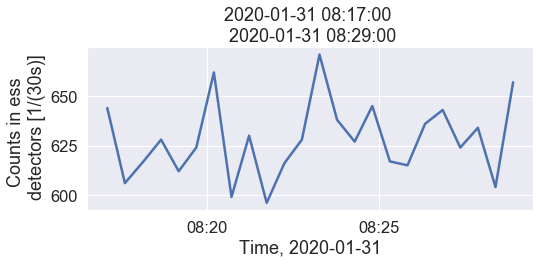

656.00, 407.00, 48.06


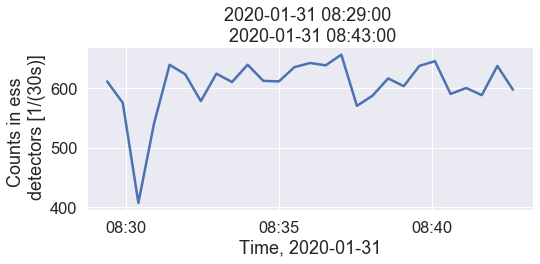

442.00, 387.00, 18.73


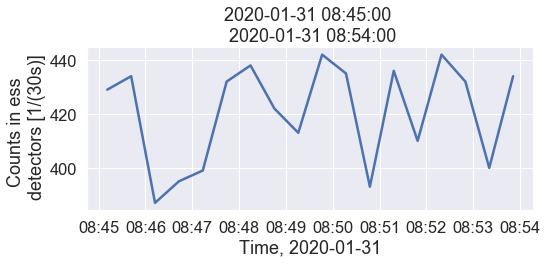

458.00, 371.00, 20.56


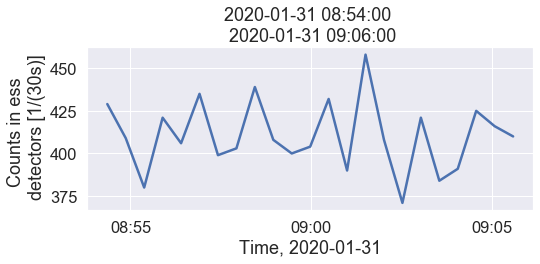

441.00, 367.00, 16.96


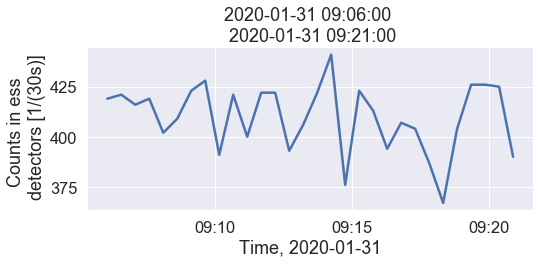

465.00, 11.00, 86.97


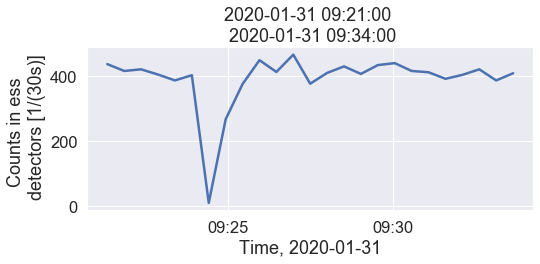

444.00, 369.00, 21.74


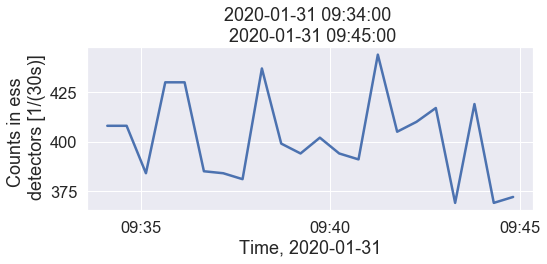

473.00, 369.00, 22.34


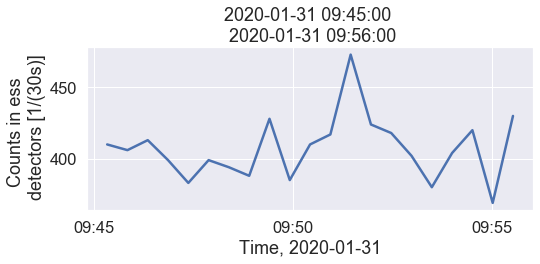

466.00, 353.00, 24.11


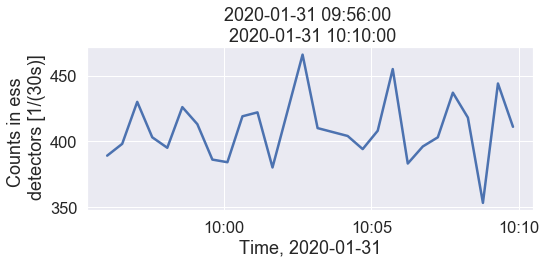

451.00, 380.00, 18.59


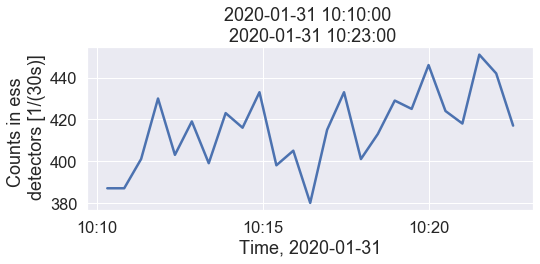

443.00, 368.00, 20.50


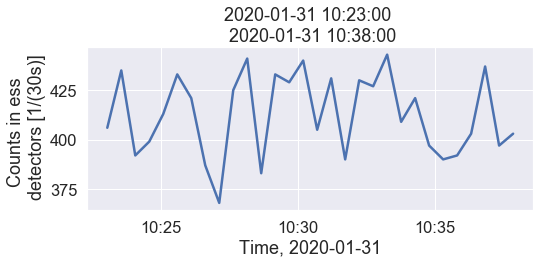

472.00, 28.00, 79.98


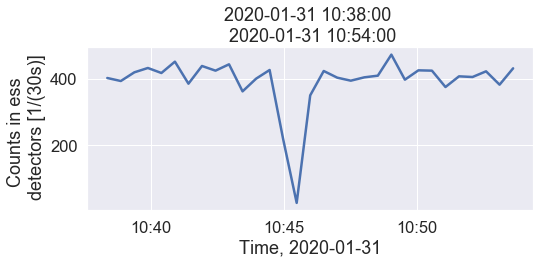

456.00, 32.00, 74.02


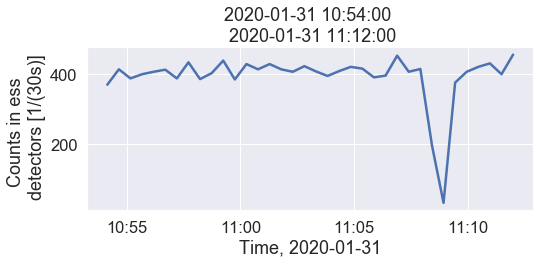

468.00, 380.00, 17.63


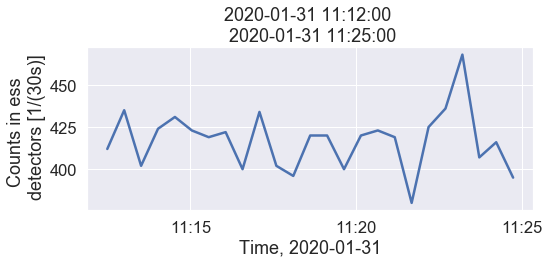

461.00, 386.00, 19.80


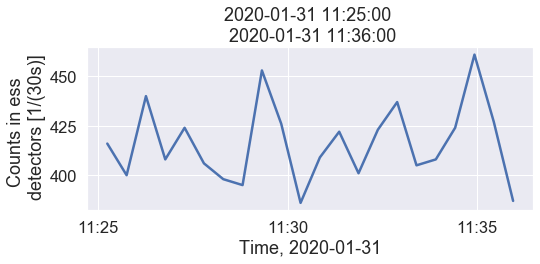

449.00, 8.00, 90.39


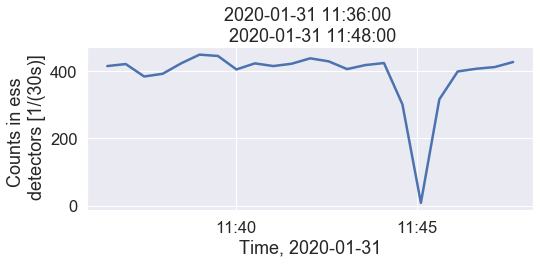

474.00, 12.00, 83.80


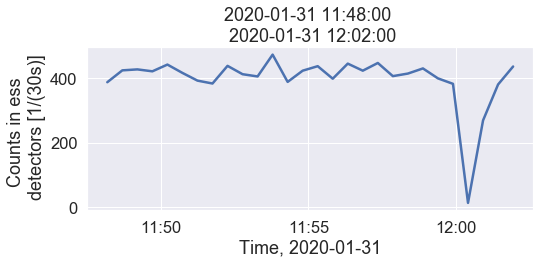

476.00, 395.00, 22.23


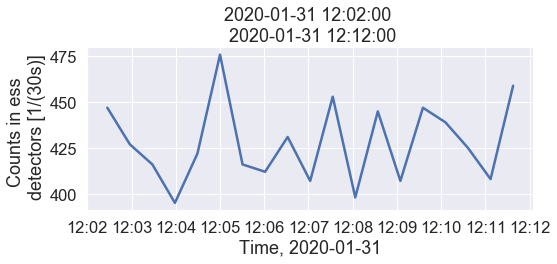

457.00, 383.00, 19.84


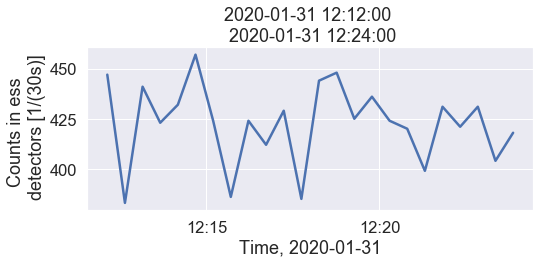

464.00, 391.00, 20.35


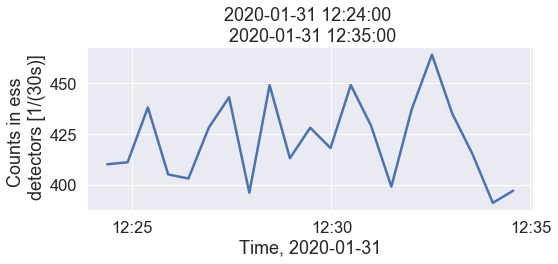

460.00, 31.00, 83.21


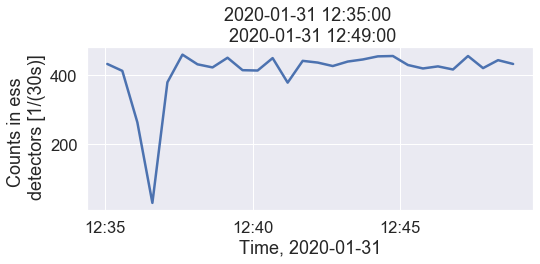

466.00, 383.00, 17.33


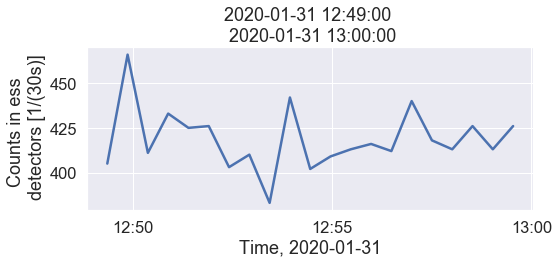

457.00, 405.00, 15.72


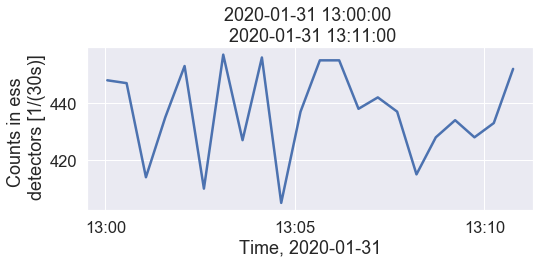

471.00, 367.00, 28.06


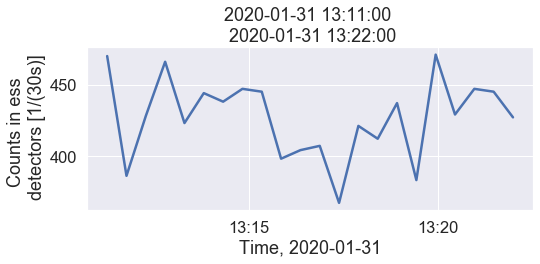

549.00, 402.00, 28.44


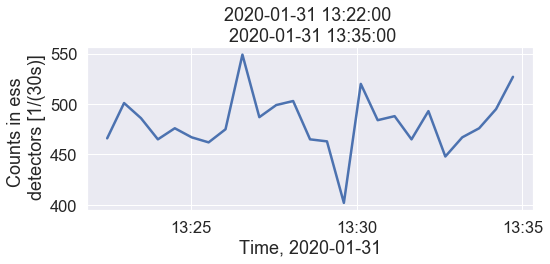

730.00, 655.00, 26.22


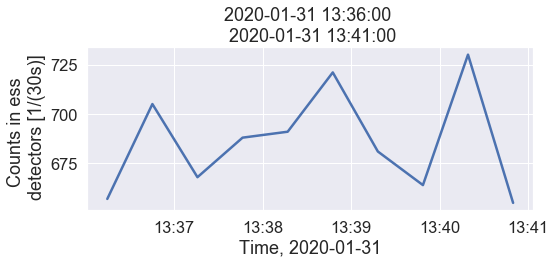

673.00, 567.00, 30.94


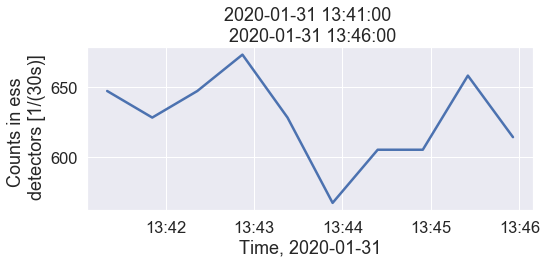

645.00, 539.00, 29.77


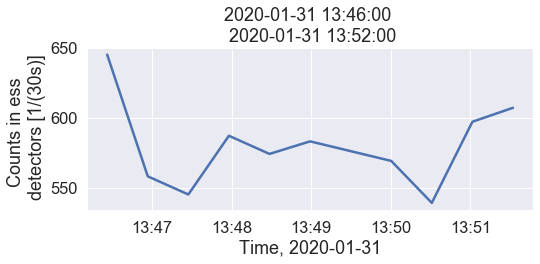

557.00, 499.00, 18.73


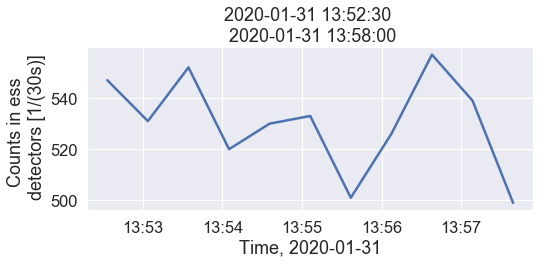

584.00, 457.00, 35.38


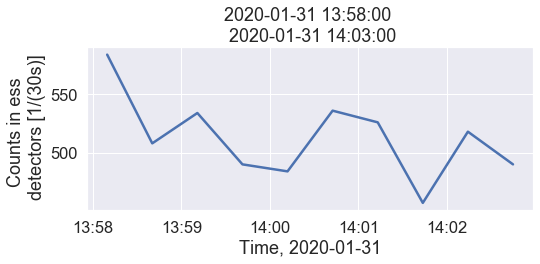

548.00, 403.00, 40.40


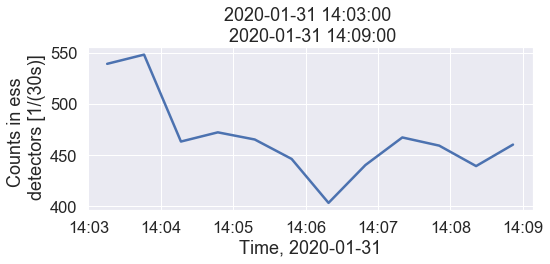

468.00, 401.00, 21.43


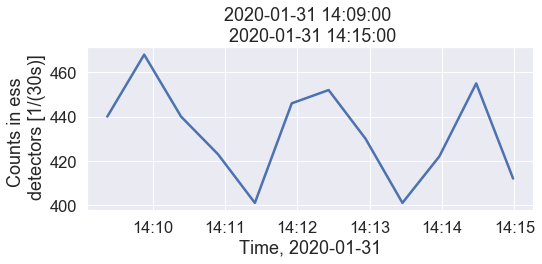

475.00, 411.00, 21.16


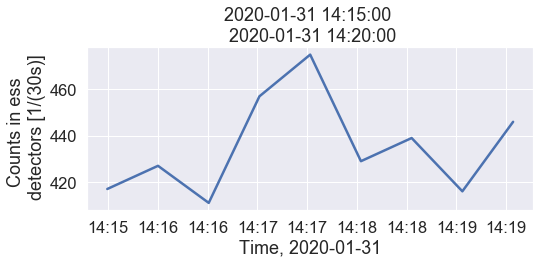

483.00, 399.00, 25.69


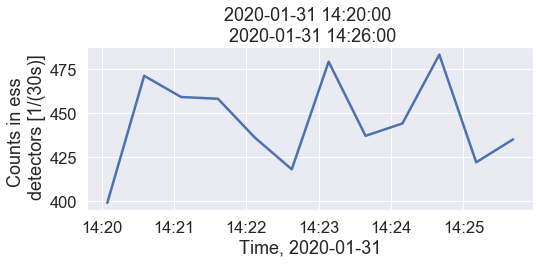

662.00, 613.00, 20.95


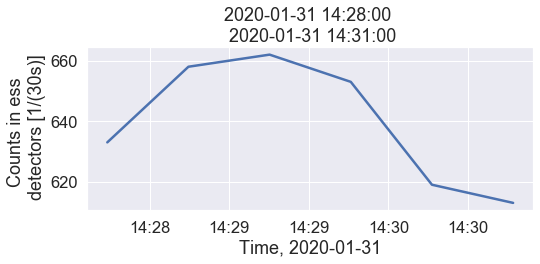

682.00, 593.00, 22.91


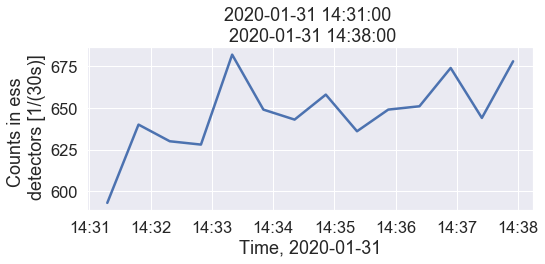

727.00, 637.00, 27.48


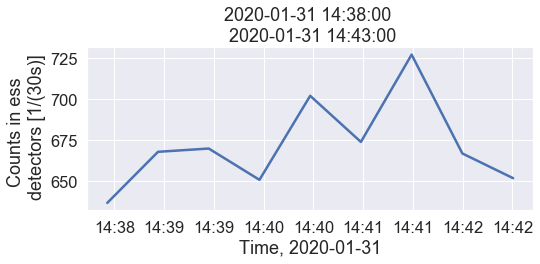

No data for ii 39 t0 2020-01-31 14:43:00 t1 NaT


In [14]:
# remove first last time

# loop through edge position
ii = 0
for ii in range(0,data_pos.shape[0]):

    # get the beginning and end time, t0 and t1
    t0 = data_pos.iloc[ii, :].loc['t0']
    t1 = data_pos.iloc[ii, :].loc['t1']
    pos = data_pos.iloc[ii, :].loc['edge_pos'] # mm
    ess_counts = data_ess[(data_ess.index >= t0) & (data_ess.index <= t1)].loc[:,'value']

    counts_max = ess_counts.max()
    counts_min = ess_counts.min()
    counts_std = ess_counts.std()
    
    if len(ess_counts)>0:

        print(f"{counts_max:.2f}, {counts_min:.2f}, {counts_std:.2f}")
        # check the counts in the ess detector, when not significantly change
        fig, ax = plt.subplots(figsize=(8,3))
        sns.set()
        sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
        sns.lineplot(x=ess_counts.index, y=ess_counts, ax=ax)
        ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
        ax.set_ylabel('Counts in ess \n detectors [1/(30s)]')
        ax.set_xlabel(f'Time, {DAY}')
        plt.title(f"{t0} \n {t1}")
        plt.show()
    else:
        print(f"No data for ii {ii} t0 {t0} t1 {t1}")



In [15]:
data_dose

,id,dose,dose_voltage,dose_corrected
time,,,,
2020-01-31 00:00:00.906481,15442333,38.1818,0.07,0.399449
2020-01-31 00:00:01.909594,15442334,49.0909,0.09,24.366400
2020-01-31 00:00:02.909222,15442335,49.0909,0.09,24.366400
2020-01-31 00:00:03.912354,15442336,49.0909,0.09,24.366400
2020-01-31 00:00:04.911966,15442337,49.0909,0.09,24.366400
...,...,...,...,...
2020-01-31 23:59:55.664280,15528513,49.0909,0.09,24.366400
2020-01-31 23:59:56.663784,15528514,49.0909,0.09,24.366400
2020-01-31 23:59:57.663154,15528515,38.1818,0.07,0.399449


In [16]:
def get_total_counts(t0, t1, pos):
    # total counts counts in the ess detector
    data_ess_counts = pd.DataFrame(data_ess[(data_ess.index >= t0) & (data_ess.index <= t1)].loc[:,'value'])
    if len(data_ess_counts) > 0:
        # emitting spot size detector
        # counting time in the ess in seconds
        ess_time = (data_ess_counts.index[-1]-data_ess_counts.index[0]).seconds
        ess_counts = data_ess_counts['value'].sum()
        # background counts during this time interval
        ess_bg_counts = counts_per_s_BG_agg * ess_time
        # background corrected counts
        ess_counts_bg_corr = ess_counts - ess_bg_counts
        # background corrected cps in ess
        ess_cps = ess_counts_bg_corr / ess_time
        
        t1 = data_ess_counts.index[-1]
        t0 = data_ess_counts.index[0]
        
        # reference detector
        # reference detector counts in that interval
        ref_data = data_reference_s[(data_reference_s.index >= t0) & (data_reference_s.index <= t1)]
        ref_total_counts = ref_data.loc[:, 'sum_counts'].sum()
        # reference detector counting time
        ref_total_time = (ref_data.index[-1]-ref_data.index[0]).seconds
        # correct reference count using its background
        ref_bg_counts = ref_counts_per_s_BG_agg * ref_total_time
        # correct the reference counts with the background counts
        ref_counts_bg_corr = ref_total_counts - ref_bg_counts
        # background corrected cps in reference
        ref_cps = ref_counts_bg_corr / ref_total_time
        
        # normalized ess cps (with reference counts)
        ess_cps_norm_ref = ess_cps / ref_cps
        
        # average dose
        avg_dose = data_dose[(data_dose.index >= t0) & (data_dose.index <= t1)].loc[:, 'dose_corrected'].mean()
        
        # counts normalized by average dose
        ess_cps_norm_dose = ess_cps / avg_dose
        s = pd.Series(
            [t0, t1, pos, ess_counts, ess_time,  
             ess_counts_bg_corr, ref_total_counts, ref_total_time, ess_cps, ref_cps, ess_cps_norm_ref, avg_dose, ess_cps_norm_dose], 
            index=['t0', 't1', 'pos', 'ess_total_counts', 'ess_total_time', 
                   'ess_counts_bg_corr', 'ref_total_counts', 'ref_total_time', 'ess_cps', 'ref_cps', 'ess_cps_norm_ref', 'avg_dose', 'ess_cps_norm_dose']
        )
        return s
    else:
        print(f"No data for t0 {t0}, t1 {t1}, pos {pos})")
        return None
# get total counts in the ess in that interval
# correct with the background (times measurement time)

# get dose in that time interval
# get reference counts in that time interval
data_result = data_pos.apply(lambda x: get_total_counts(x['t0'], x['t1'], x['edge_pos']), axis=1)
data_result

No data for t0 2020-01-31 14:43:00, t1 NaT, pos NaT)


,t0,t1,pos,ess_total_counts,ess_total_time,ess_counts_bg_corr,ref_total_counts,ref_total_time,ess_cps,ref_cps,ess_cps_norm_ref,avg_dose,ess_cps_norm_dose
time,,,,,,,,,,,,,
2020-01-31 07:57:00,2020-01-31 07:57:14.505453,2020-01-31 08:06:55.596044,25.00,13010.0,581.0,12959.258246,82868.0,564.0,22.305092,144.372851,0.154496,688.602509,0.032392
2020-01-31 08:07:00,2020-01-31 08:07:26.173739,2020-01-31 08:16:36.652158,23.00,11921.0,550.0,11872.965637,71558.0,493.0,21.587210,142.591846,0.151392,677.139324,0.031880
2020-01-31 08:17:00,2020-01-31 08:17:07.230820,2020-01-31 08:28:52.367661,21.00,15073.0,705.0,15011.428680,95263.0,669.0,21.292807,139.839886,0.152266,680.384762,0.031295
2020-01-31 08:29:00,2020-01-31 08:29:22.947814,2020-01-31 08:42:38.134742,19.00,16310.0,795.0,16240.568512,105165.0,740.0,20.428388,139.558637,0.146379,688.034547,0.029691
2020-01-31 08:45:00,2020-01-31 08:45:11.058814,2020-01-31 08:53:50.991621,17.00,7573.0,519.0,7527.673028,66158.0,458.0,14.504187,141.893554,0.102219,694.632162,0.020880
2020-01-31 08:54:00,2020-01-31 08:54:21.585025,2020-01-31 09:05:34.410666,15.00,9439.0,672.0,9380.310742,90444.0,634.0,13.958796,140.099924,0.099635,701.297110,0.019904
2020-01-31 09:06:00,2020-01-31 09:06:04.987782,2020-01-31 09:20:51.972870,13.00,12297.0,886.0,12219.621008,119953.0,846.0,13.791897,139.232189,0.099057,703.882768,0.019594
2020-01-31 09:21:00,2020-01-31 09:21:22.552738,2020-01-31 09:33:36.549849,11.00,9767.0,733.0,9702.983294,95382.0,705.0,13.237358,132.737390,0.099726,663.638447,0.019947
2020-01-31 09:34:00,2020-01-31 09:34:07.143876,2020-01-31 09:44:49.402924,9.00,8832.0,642.0,8775.930798,86725.0,599.0,13.669674,142.226744,0.096112,710.389619,0.019243


## Visualize the ess

In [17]:
# normalize by the max 
edge_fully_out = data_result[data_result['pos'] == 25].loc[:,'ess_cps_norm_ref'].values.mean()
data_result['ess_cps_norm_ref_scaled'] = data_result['ess_cps_norm_ref']/edge_fully_out

edge_fully_out = data_result[data_result['pos'] == 25].loc[:,'ess_cps_norm_dose'].values.mean()
data_result['ess_cps_norm_dose_scaled'] = data_result['ess_cps_norm_dose']/edge_fully_out


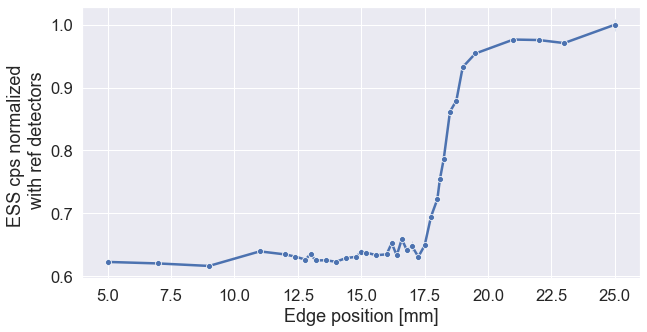

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x='pos', y='ess_cps_norm_ref_scaled', data=data_result, ax=ax, marker="o")

ax.set_ylabel('ESS cps normalized \n with ref detectors')
ax.set_xlabel(f'Edge position [mm]')

plt.show()

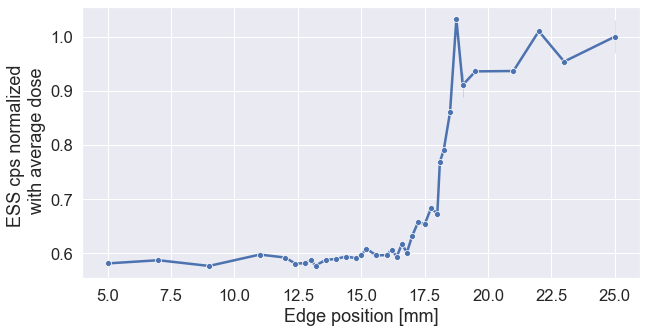

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x='pos', y='ess_cps_norm_dose_scaled', data=data_result, ax=ax, marker="o")

ax.set_ylabel('ESS cps normalized \n with average dose')
ax.set_xlabel(f'Edge position [mm]')

plt.show()

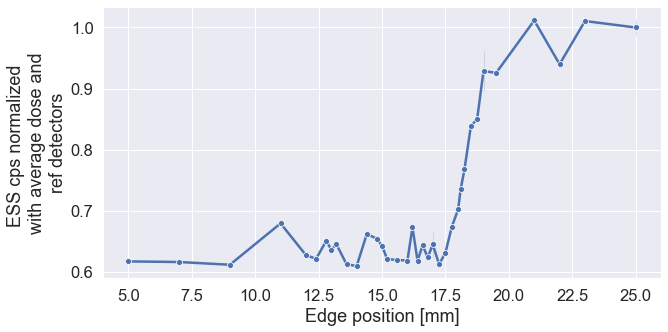

In [20]:
# scale with ref and avg dose
data_result['ess_cps_norm_dose_and_ref'] = data_result['ess_cps_norm_ref'] / data_result['avg_dose']
edge_fully_out = data_result[data_result['pos'] == 25].loc[:,'ess_cps_norm_dose_and_ref'].values.mean()
data_result['ess_cps_norm_dose_and_ref_scaled'] = data_result['ess_cps_norm_dose_and_ref']/edge_fully_out
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x='pos', y='ess_cps_norm_dose_and_ref_scaled', data=data_result, ax=ax, marker="o")

ax.set_ylabel('ESS cps normalized \n with average dose and \nref detectors')
ax.set_xlabel(f'Edge position [mm]')

plt.show()

# Continue with reference detector normed and fit ESF

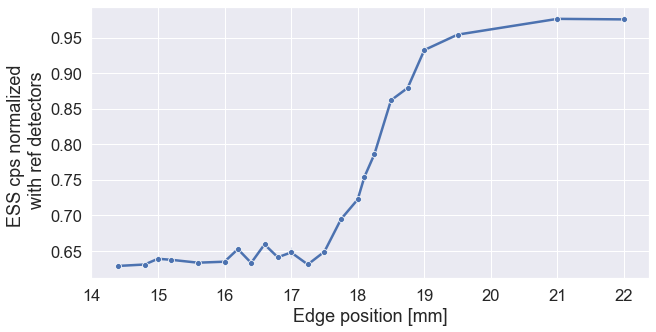

In [21]:
# limit the position
pos_min = 14
pos_max = 23
data_result_s = data_result[(data_result['pos'] > pos_min) & (data_result['pos'] < pos_max)]

fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x='pos', y='ess_cps_norm_ref_scaled', data=data_result_s, ax=ax, marker="o")

ax.set_ylabel('ESS cps normalized \n with ref detectors')
ax.set_xlabel(f'Edge position [mm]')
ax.set_xticks(np.arange(14,23,1))
plt.show()

In [22]:
thresh_out = 21  # edge completely removed
thresh_in = 15.5  # edge completely in

mu_out = np.mean(data_result.ess_cps_norm_ref_scaled[ data_result.pos > thresh_out ])
mu_in = np.mean(data_result.ess_cps_norm_ref_scaled[ data_result.pos < thresh_in ])
print(f'Mean of counts when edge is out: {mu_out}')
print(f'Mean of counts when edge is in: {mu_in}')

Mean of counts when edge is out: 0.9866054775470751
Mean of counts when edge is in: 0.6290364250329682


Mean of counts when edge is out: 0.9866054775470751
Mean of counts when edge is in: 0.6290364250329682


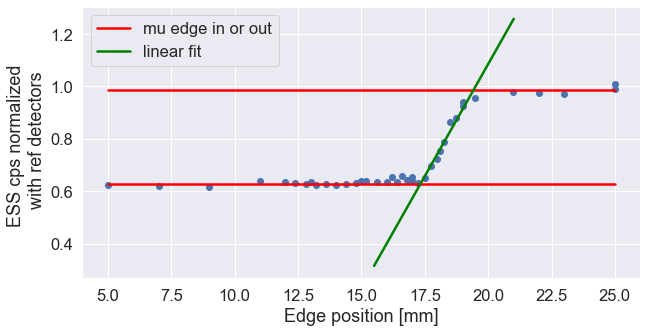

[17.34 19.43]
Center point (symmetry) is 18.384999999999938 mm.


In [23]:
thresh_out = 21  # edge completely removed
thresh_in = 15.5  # edge completely in

mu_out = np.mean(data_result.ess_cps_norm_ref_scaled[ data_result.pos > thresh_out ])
mu_in = np.mean(data_result.ess_cps_norm_ref_scaled[ data_result.pos < thresh_in ])
print(f'Mean of counts when edge is out: {mu_out}')
print(f'Mean of counts when edge is in: {mu_in}')

# linear fit around the middle region
center_estimated = 18.5  # edge pos center estimated in mm
pts_fit = 1  # mm left and right of center to take for fit
x_fit_range1 = center_estimated + pts_fit
x_fit_range2 = center_estimated - pts_fit
def fitfunc(p, x):
    return p[0] * x + p[1]
def errfunc(p, x, y):
    return fitfunc(p, x) - y # Distance to the fit function

p0 = [1, 1] # Initial guess for the parameters
X_f = data_result.pos[ (data_result.pos <= x_fit_range1) & (data_result.pos >= x_fit_range2) ].values
Y_f = data_result.ess_cps_norm_ref_scaled[ (data_result.pos <= x_fit_range1) & (data_result.pos >= x_fit_range2) ].values

p1, success = optimize.leastsq(errfunc, p0[:], args=(X_f, Y_f))
X_fit = np.arange(15.5,21+0.01,0.01)
Y_fit = fitfunc(p1,X_fit)

# this code plots the centering
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.scatter(data_result.pos, data_result.ess_cps_norm_ref_scaled)
plt.plot([data_result.pos.min(), data_result.pos.max()], [mu_in, mu_in], c='red', label='mu edge in or out')
plt.plot([data_result.pos.min(), data_result.pos.max()], [mu_out, mu_out], c='red')

plt.plot(X_fit, Y_fit, c='green', label='linear fit')
plt.xlabel('Edge position [mm]')
plt.ylabel('ESS cps normalized \n with ref detectors')
plt.grid(True)
plt.legend(loc='best')
plt.show()



# find where the linear fit intersects the mean curved (edge fully in or fully out curve)
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

near_mu = np.array([])  # first entry: edge fully in, second entry: edge fully out in mm edge position
for mu in [mu_in, mu_out]:
    idx = find_nearest(Y_fit, mu)
    near_mu = np.append(near_mu,X_fit[idx])

# center is in between the two
center = np.mean(near_mu)
print(near_mu)
print(f"Center point (symmetry) is {center} mm.")

In [24]:
data_result['pos_centered'] = data_result['pos'] - center
data_result.head()

,t0,t1,pos,ess_total_counts,ess_total_time,ess_counts_bg_corr,ref_total_counts,ref_total_time,ess_cps,ref_cps,ess_cps_norm_ref,avg_dose,ess_cps_norm_dose,ess_cps_norm_ref_scaled,ess_cps_norm_dose_scaled,ess_cps_norm_dose_and_ref,ess_cps_norm_dose_and_ref_scaled,pos_centered
time,,,,,,,,,,,,,,,,,,
2020-01-31 07:57:00,2020-01-31 07:57:14.505453,2020-01-31 08:06:55.596044,25.0,13010.0,581.0,12959.258246,82868.0,564.0,22.305092,144.372851,0.154496,688.602509,0.032392,0.990697,0.969279,0.000224,1.014150,6.615
2020-01-31 08:07:00,2020-01-31 08:07:26.173739,2020-01-31 08:16:36.652158,23.0,11921.0,550.0,11872.965637,71558.0,493.0,21.587210,142.591846,0.151392,677.139324,0.031880,0.970787,0.953964,0.000224,1.010592,4.615
2020-01-31 08:17:00,2020-01-31 08:17:07.230820,2020-01-31 08:28:52.367661,21.0,15073.0,705.0,15011.428680,95263.0,669.0,21.292807,139.839886,0.152266,680.384762,0.031295,0.976392,0.936465,0.000224,1.011578,2.615
2020-01-31 08:29:00,2020-01-31 08:29:22.947814,2020-01-31 08:42:38.134742,19.0,16310.0,795.0,16240.568512,105165.0,740.0,20.428388,139.558637,0.146379,688.034547,0.029691,0.938641,0.888459,0.000213,0.961655,0.615
2020-01-31 08:45:00,2020-01-31 08:45:11.058814,2020-01-31 08:53:50.991621,17.0,7573.0,519.0,7527.673028,66158.0,458.0,14.504187,141.893554,0.102219,694.632162,0.020880,0.655470,0.624816,0.000147,0.665163,-1.385


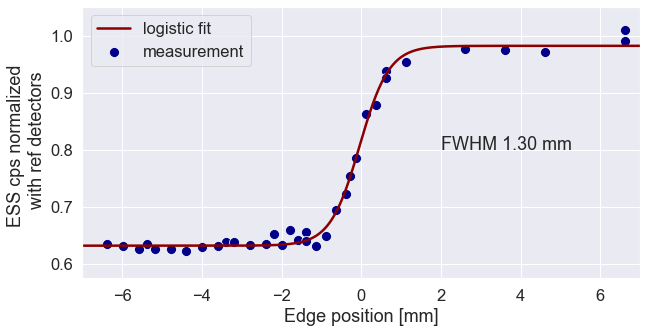

In [25]:
m = [1e-2, 5e-2, 1e-1, 5e-1, 0, 1, 5, 1e1]
x = data_result['pos_centered'].values
x = x[~np.isnan(x)]
y = data_result['ess_cps_norm_ref_scaled'].values
y = y[~np.isnan(y)]
def fitfunc(x, *p):
    a, b, c, d = p
    z = np.exp( -( (x-b)/(c) ) )
    # z = np.exp( -( (x-p[1])/(p[2]) ) )
    return (a / ( 1 + z )) + d
    # return (p[0] / ( 1 + z )) + p[3]

p0 = [1,1,1,1]
popt, pcov = curve_fit(fitfunc, x, y, p0=p0, maxfev=1000000)
# print(popt)
FWHM = 3.53*popt[2]  # 3.53 * c in fermi function
# print(FWHM)
X = np.arange(-10, 10+0.01, 0.01)
Y_fit = fitfunc(X, *popt)
    
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.scatterplot(x=data_result['pos_centered'], y=data_result['ess_cps_norm_ref_scaled'], color='darkblue', ax=ax, s=100, label='measurement')
sns.lineplot(x=X,y=Y_fit, color='darkred', ax=ax, label='logistic fit')
ax.set_ylabel('ESS cps normalized \n with ref detectors')
ax.set_xlabel(f'Edge position [mm]')
plt.text(2, 0.8, f'FWHM {FWHM:.2f} mm')
# ax.set_xticks(np.arange(-7.5,7.5+2,2))
plt.xlim(-7,7)
plt.show()